# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
random_state = 12345

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=random_state
                                                  )

Found 7591 validated image filenames.


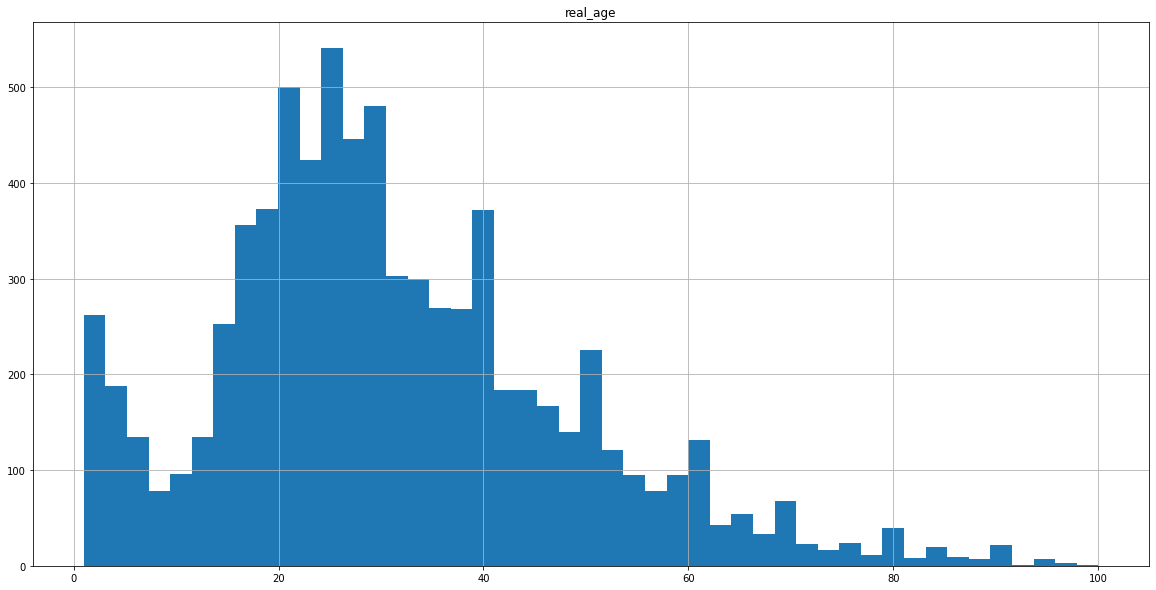

In [12]:
labels.hist(bins='auto', figsize=(20,10));

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


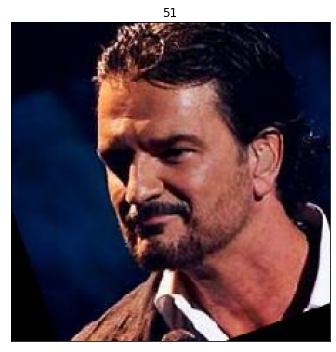

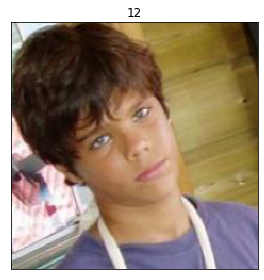

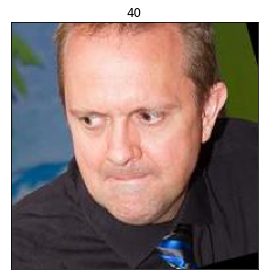

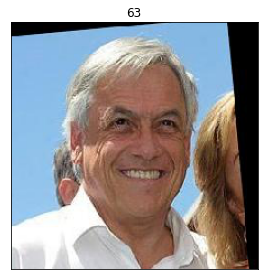

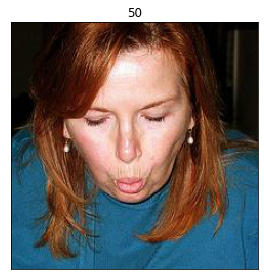

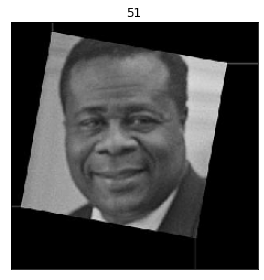

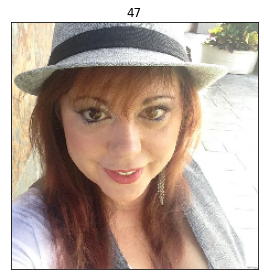

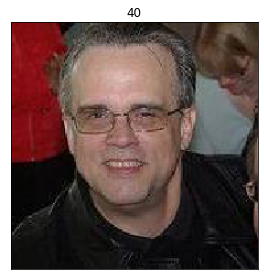

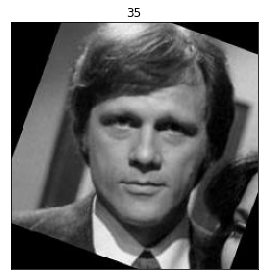

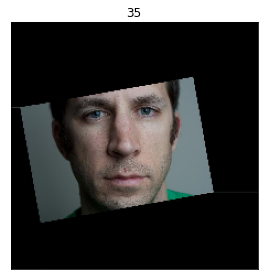

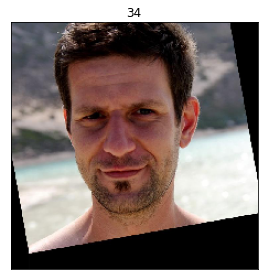

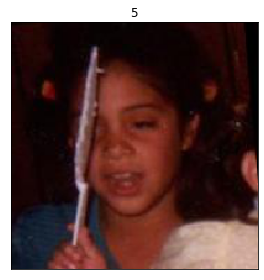

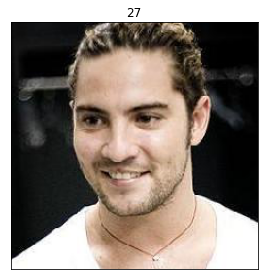

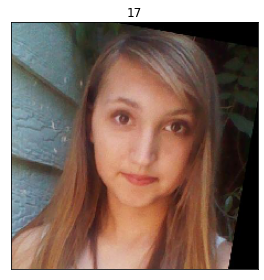

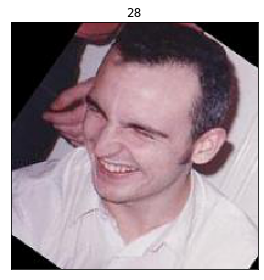

In [5]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(5,5))
for i in range(15):
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()
    plt.show()

<b>Вывод:</b><br>
В датафрейме 7591 фото. Больше всего людей 20-41 год (медиана 29 лет, основное скопление 20-30 лет, максимум 26 лет). Минимум- 1 год, масимум 100 лет (на грани. таких много вроде не бывает). <br>
Есть всплеск на первых пяти годах, и рядом минимум (локальный). И ещё один всплеск на 40 годах.<br>
Расы разные, пол тоже. Есть повёрнутые, есть ч/б, есть с дефектами (расплывчатые, недогруженные, возможно ещё что-то).

## Обучение модели

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       horizontal_flip=True,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=random_state)
 
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=random_state)
 
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, epochs=5,
                batch_size=None, steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

2023-09-23 12:07:05.668920: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-09-23 12:07:05.670772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-09-23 12:07:06.547607: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-23 12:07:06.556437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-23 12:07:06.556504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-23 12:07:06.556535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-23 12:07:06.558473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-23 12:07:06.558867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-23 12:07:06.561030: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-23 12:07:06.562276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-23 12:07:06.562332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-23 12:07:06.565326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-09-23 12:07:06.737543: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-09-23 12:07:06.744210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-09-23 12:07:06.744735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5911fd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-23 12:07:06.744762: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-23 12:07:06.890881: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f72130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-23 12:07:06.890918: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-09-23 12:07:06.892631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-23 12:07:06.892686: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-23 12:07:06.892695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-23 12:07:06.892721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-23 12:07:06.892730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-23 12:07:06.892739: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-23 12:07:06.892748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-23 12:07:06.892755: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-23 12:07:06.896038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-09-23 12:07:06.896099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-23 12:07:07.218592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-23 12:07:07.218646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-09-23 12:07:07.218654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-09-23 12:07:07.221954: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-23 12:07:07.222006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 9s
   65536/94765736 [..............................] - ETA: 1:14
  245760/94765736 [..............................] - ETA: 42s 
  688128/94765736 [..............................] - ETA: 21s
 1884160/94765736 [..............................] - ETA: 10s
 4644864/94765736 [>.............................] - ETA: 5s 
 8708096/94765736 [=>............................] - ETA: 3s
12992512/94765736 [===>..........................] - ETA: 2s
16293888/94765736 [====>.........................] - ETA: 2s
19398656/94765736 [=====>........................] - ETA: 1s
22560768/94765736 [======>.......................] - ETA: 1s
27181056/94765736 [=======>......................] - ETA: 1s
30834688/94765736 [========>.....................] - ETA: 1s
34160640/94765736 [=========>....................] - ETA: 1s
38428672/94765736 [===========>..................] - ETA: 1s
42688512/94765736 [============>.................] - ETA: 1s
46964736/94765736 [=============>................] - ETA: 0s
51232768/94765736 [===============>..............] - ETA: 0s
55508992/94765736 [================>.............] - ETA: 0s
59777024/94765736 [=================>............] - ETA: 0s
64053248/94765736 [===================>..........] - ETA: 0s
67174400/94765736 [====================>.........] - ETA: 0s
70664192/94765736 [=====================>........] - ETA: 0s
72581120/94765736 [=====================>........] - ETA: 0s
76857344/94765736 [=======================>......] - ETA: 0s
81043456/94765736 [========================>.....] - ETA: 0s
83886080/94765736 [=========================>....] - ETA: 0s
85393408/94765736 [==========================>...] - ETA: 0s
89661440/94765736 [===========================>..] - ETA: 0s
93929472/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 2s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-09-23 12:07:19.850994: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-23 12:07:20.146310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 11.3058 - mae: 11.3074 - val_loss: 12.8436 - val_mae: 12.8296
Epoch 2/5
356/356 - 42s - loss: 7.5456 - mae: 7.5455 - val_loss: 11.0686 - val_mae: 11.0539
Epoch 3/5
356/356 - 41s - loss: 6.6246 - mae: 6.6242 - val_loss: 7.4478 - val_mae: 7.4466
Epoch 4/5
356/356 - 41s - loss: 5.9314 - mae: 5.9315 - val_loss: 7.0143 - val_mae: 7.0200
Epoch 5/5
356/356 - 41s - loss: 5.2846 - mae: 5.2847 - val_loss: 6.5193 - val_mae: 6.5279
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.5193 - mae: 6.5279
Test MAE: 6.5279

## Анализ обученной модели

<b>Вывод:</b><br>
Для решения задачи использовал ResNet50 с добавлением своего GlobalAveragePooling2D. за 5 эпох МАЕ на тренирвочной выборке упало с 11.3 до 5.3 а на тестовой с 12.8 до 6.5 (для решения задачи был установлен порог в 8.) т.о. задача решена<br>